In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.20.0
Num GPUs Available:  0


/Users/srimohanapriyan/Documents/REAL TIME PROJECTS/Pneumonia_Detection/deep_learning/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Data Pipelines 
# Here we creating "Generators" that stream images from our hard drive to the model in small batches. This step saves our RAM.

In [2]:
TRAIN_DIR = '../dataset/train'
TEST_DIR = '../dataset/test' 

# 2. Setup Data Generators
# We add "Data Augmentation" to training (zoom, shear) to make the model smarter
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values
    shear_range=0.2,      # Tilt image slightly
    zoom_range=0.2,       # Zoom in slightly
    horizontal_flip=True, # Flip left/right
    validation_split=0.2  # Use 20% of training data to check accuracy
)

test_datagen = ImageDataGenerator(rescale=1./255) 

# 3. Load the Images
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',     
    subset='training'
)

# "subset='validation'" gives us the 20%
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print(f"Class Indices: {train_generator.class_indices}")

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}


# BUILDING THE MODEL (VGG16)

In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Freeze the Base Layers
# We don't want to "un-learn" what VGG16 already knows about shapes/edges
for layer in base_model.layers:
    layer.trainable = False

# 3. Add Custom Layers
x = Flatten()(base_model.output)            # Flatten 2D maps to 1D vector
x = Dense(512, activation='relu')(x)        # Dense layer for learning complex patterns
x = Dropout(0.5)(x)                         # Dropout to prevent overfitting
output = Dense(1, activation='sigmoid')(x)  # Single output (0=Normal, 1=Pneumonia)

# 4. Final Model
model = Model(inputs=base_model.input, outputs=output)

# 5. Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Low learning rate for fine-tuning
    loss='binary_crossentropy',           # Standard loss for binary classification
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# TRAINING THE MODEL

In [4]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10 
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.9053 - loss: 0.2265 - val_accuracy: 0.9559 - val_loss: 0.1204
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9487 - loss: 0.1326 - val_accuracy: 0.9521 - val_loss: 0.1284
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 516s 4s/step - accuracy: 0.9542 - loss: 0.1245 - val_accuracy: 0.9607 - val_loss: 0.1056
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1402s 11s/step - accuracy: 0.9638 - loss: 0.1067 - val_accuracy: 0.9578 - val_loss: 0.1046
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9564 - loss: 0.1124 - val_accuracy: 0.9597 - val_loss: 0.1066
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 676s 5s/step - accuracy: 0.9653 - loss: 0.1000 - val_accuracy: 0.9655 - val_loss: 0.0823
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9626 - loss: 0.0986 - val_accuracy: 0.9492 - val_loss: 0.1172
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 894s 7s/step - accuracy: 0.9633 - loss: 0.0969 - val_ac

# SAVE THE MODEL

In [5]:
model.save('pneumonia_model.h5')
print("✅ Model saved successfully as pneumonia_model.h5")

✅ Model saved successfully as pneumonia_model.h5


# PLOTING THE MODEL TO CHECK HOW IT DID

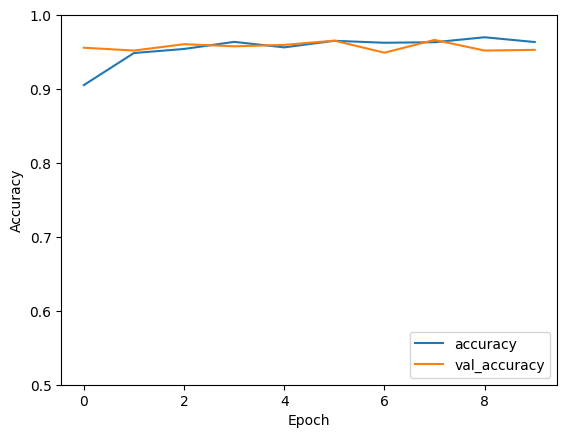

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()